In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import models, layers, optimizers
import matplotlib.image as mpimg
import math

In [3]:
BASE_DIR = '../input/intel-image-classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'seg_train/seg_train')
TEST_DIR = os.path.join(BASE_DIR, 'seg_test/seg_test')
PRED_DIR = os.path.join(BASE_DIR, 'seg_pred/seg_pred')

In [4]:
# Image Data generator for training data
TRAIN_DATAGEN = ImageDataGenerator(rescale=1.0/255, validation_split=0.2)

TEST_DATAGEN = ImageDataGenerator(rescale=1.0/255)
BATCH_SIZE = 20
EPOCHS = 30

In [5]:
os.listdir(TRAIN_DIR + '/' + 'buildings')[2]

'10730.jpg'

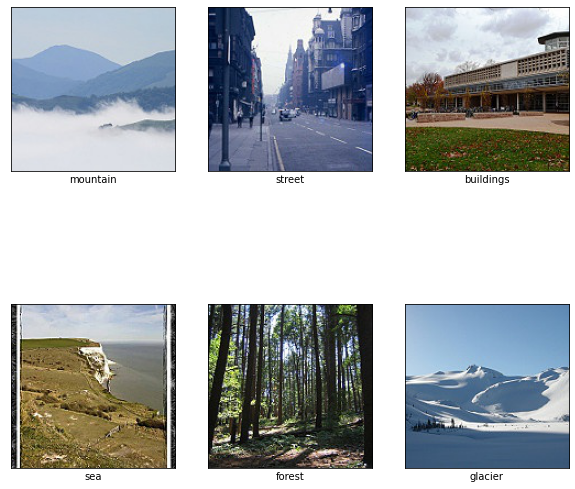

In [6]:
# Lets see images of each class
j=0
fig=plt.figure(figsize=(10, 10))
for i in os.listdir(TRAIN_DIR):
        img = mpimg.imread(TRAIN_DIR+"/"+i+"/"+os.listdir(TRAIN_DIR+"/"+i)[0])
        fig.add_subplot(2,3,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(i)
        j += 1
plt.show()

In [7]:
print('Training Data :')
for i in os.listdir(TRAIN_DIR):
    files = os.listdir(TRAIN_DIR + '/' + i +'/')
    print(i ,":", len(files))
    
print("\n")    
print('Test Data :')
for i in os.listdir(TEST_DIR):
    files = os.listdir(TEST_DIR + '/' + i + '/')
    print(i, ':', len(files))

Training Data :
mountain : 2512
street : 2382
buildings : 2191
sea : 2274
forest : 2271
glacier : 2404


Test Data :
mountain : 525
street : 501
buildings : 437
sea : 510
forest : 474
glacier : 553


Almost same number of samples for each class, hence no class-imbalance problem.

We have two options to build a model

Convolutional Neural Network from scratch
Feature Extraction using pretrained networks
On an average, for every class we have 2300 images in training data, which is less. If we build a convnet from scratch, there are high chances that it will overfit the training data. So option-1 does not seem to be a good one.

Let's see second option.

A pretrained network is a saved network that was previously trained on a large dataset, typically on large-scale image classification task. If the original dataset is large enough and general enough, then the spatial hierarchy of features learned by the network can effectively act as a generic model of the visual world and hence it's features can be useful for many different image classification tasks.

We will use pretrained VGG16 model. This model was trained on ImageNet dataset for 1000 classes. Features learned by the initial layers of VGG16 model are generic enough to apply for other image classification tasks.

Let's go with feature extraction using pretrained VGG16 model.

In [8]:
train_generator = TRAIN_DATAGEN.flow_from_directory(TRAIN_DIR, target_size=(150,150),batch_size=BATCH_SIZE, 
                                                    class_mode='categorical', subset='training' )
test_generator = TEST_DATAGEN.flow_from_directory(TEST_DIR, target_size=(150,150), batch_size=BATCH_SIZE, 
                                                  class_mode='categorical')
Validation_generator = TRAIN_DATAGEN.flow_from_directory(TRAIN_DIR, target_size=(150,150), batch_size=BATCH_SIZE, 
                                                         class_mode='categorical', subset='validation')

Found 11230 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.


Load the VGG16's convolution base

In [9]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

58892288/58889256 [==============================] - 1s 0us/step


In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Let's define model with its own classifier on top of VGG16 convolution base 

In [11]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(250,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [12]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Nadam(lr=2e-5), metrics=['acc'])

In [13]:
hist = model.fit_generator(train_generator, steps_per_epoch =train_generator.samples//BATCH_SIZE, 
                          epochs=EPOCHS, validation_data=Validation_generator, 
                           validation_steps=Validation_generator.samples//BATCH_SIZE)

Epoch 1/30
561/561 [==============================] - 80s 143ms/step - loss: 0.5130 - acc: 0.8127 - val_loss: 0.2985 - val_acc: 0.8864
Epoch 2/30
561/561 [==============================] - 58s 104ms/step - loss: 0.2529 - acc: 0.9141 - val_loss: 0.2301 - val_acc: 0.9189
Epoch 3/30
561/561 [==============================] - 59s 104ms/step - loss: 0.1951 - acc: 0.9315 - val_loss: 0.2225 - val_acc: 0.9221
Epoch 4/30
561/561 [==============================] - 58s 104ms/step - loss: 0.1450 - acc: 0.9499 - val_loss: 0.2211 - val_acc: 0.9318
Epoch 5/30
561/561 [==============================] - 59s 105ms/step - loss: 0.1161 - acc: 0.9596 - val_loss: 0.2247 - val_acc: 0.9279
Epoch 6/30
561/561 [==============================] - 59s 105ms/step - loss: 0.0901 - acc: 0.9686 - val_loss: 0.2762 - val_acc: 0.9121
Epoch 7/30
561/561 [==============================] - 58s 104ms/step - loss: 0.0710 - acc: 0.9775 - val_loss: 0.2753 - val_acc: 0.9200
Epoch 8/30
561/561 [==============================] - 5

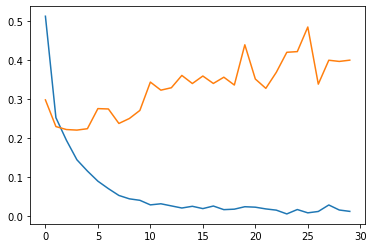

In [15]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='test')
plt.show()

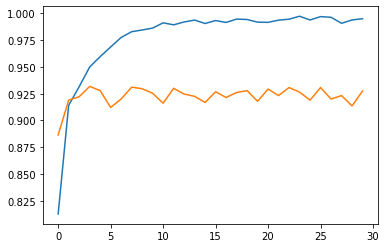

In [18]:
plt.plot(hist.history['acc'],  label='train')
plt.plot(hist.history['val_acc'], label='test')
plt.show()

Let's push the performance a bit further by fine-tuning the VGG16 model.

In fine-tuning we slightly adjust the more abstract representations of the model being reused, in order to make them more relevant to the problem at hand. We are going to unfreez last block convolution layers of the model. To limit the magnitude of modification made to pretrained representations, let's keep small learning rate.

In [19]:
conv_base.trainable= True

set_trainable = False

for layer in conv_base.layers:    
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable == True:
        layer.trainable = True
    else:
        layer.trainable = False
    
    

In [22]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Nadam(lr= 2e-5), metrics=['acc'])
hist= model.fit_generator(train_generator,
                         steps_per_epoch = train_generator.samples//BATCH_SIZE, 
                         epochs=EPOCHS, 
                         validation_data=Validation_generator,
                         validation_steps=Validation_generator.samples//BATCH_SIZE)

Epoch 1/30
561/561 [==============================] - 29s 53ms/step - loss: 0.0057 - acc: 0.9979 - val_loss: 0.4428 - val_acc: 0.9318
Epoch 2/30
561/561 [==============================] - 28s 51ms/step - loss: 0.0028 - acc: 0.9989 - val_loss: 0.4638 - val_acc: 0.9318
Epoch 3/30
561/561 [==============================] - 29s 53ms/step - loss: 0.0026 - acc: 0.9986 - val_loss: 0.4513 - val_acc: 0.9318
Epoch 4/30
561/561 [==============================] - 28s 50ms/step - loss: 0.0039 - acc: 0.9985 - val_loss: 0.4881 - val_acc: 0.9332
Epoch 5/30
561/561 [==============================] - 30s 53ms/step - loss: 0.0040 - acc: 0.9985 - val_loss: 0.5049 - val_acc: 0.9332
Epoch 6/30
561/561 [==============================] - 29s 52ms/step - loss: 0.0021 - acc: 0.9990 - val_loss: 0.5687 - val_acc: 0.9314
Epoch 7/30
561/561 [==============================] - 30s 53ms/step - loss: 0.0024 - acc: 0.9989 - val_loss: 0.5818 - val_acc: 0.9286
Epoch 8/30
561/561 [==============================] - 29s 53ms

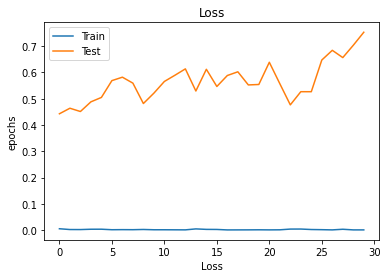

In [23]:
plt.plot(hist.history['loss'], label='Train')
plt.plot(hist.history['val_loss'], label='Test')
plt.title('Loss')
plt.xlabel('Loss')
plt.ylabel('epochs')
plt.legend()
plt.show()

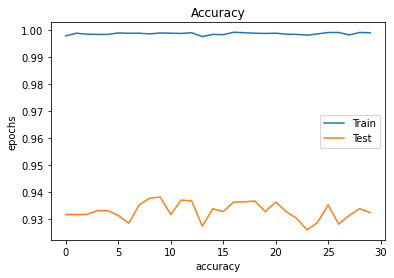

In [24]:
plt.plot(hist.history['acc'], label='Train')
plt.plot(hist.history['val_acc'], label='Test')
plt.title('Accuracy')
plt.xlabel('accuracy')
plt.ylabel('epochs')
plt.legend()
plt.show()

Let's apply the model on test_data

In [26]:
test_acc, test_loss = model.evaluate_generator(test_generator,steps=test_generator.samples//BATCH_SIZE)
print(test_acc)

0.8245183825492859
